In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from Bio import PDB
from Bio.SeqUtils import seq3
from sklearn.metrics.pairwise import euclidean_distances

In [7]:
# Read in pdb file and get list of chains

pic_fp = "pdb/7eg9.pdb.gz"

with gzip.open(pic_fp, 'rt') as f:
    parse=PDB.PDBParser(QUIET=True)
    pic=parse.get_structure("pic", f)
    chain_ids = [chain.get_id() for chain in pic[0]]

print(chain_ids)

['A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'c', 'd', 'e', 'f', 'i', 'j', 'k', 'l', 'm', 'o', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z', 'u']


In [8]:
template = "AAGGGCGCCTATAAAAGGGGGTGGGGGCGCGTTCGTCCTCAGTCGCGATCGAACACTCGAGCCGAGCAGACGTGCCTAC"
print(template)

AAGGGCGCCTATAAAAGGGGGTGGGGGCGCGTTCGTCCTCAGTCGCGATCGAACACTCGAGCCGAGCAGACGTGCCTAC


In [9]:
# Extract template and nontemplate strands from pdb file

template_structure = pic[0]["X"]
nontemplate_structure = pic[0]["Y"]

template_structure_seq = "".join(
    [res.get_resname()[-1] for res in list(template_structure.get_residues())]
)
nontemplate_structure_seq = "".join(
    [res.get_resname()[-1] for res in list(nontemplate_structure.get_residues())]
)

In [10]:
# Get coordinates of atoms for each residue in template and nontemplate strands

template_coords = {}
for i in range(len(template_structure_seq)):
    residue = list(template_structure.get_residues())[i]
    atoms_list = residue.get_atoms()
    residue_coords = [atom.get_coord() for atom in atoms_list]
    template_coords[i] = (residue.get_resname(), residue_coords)

nontemplate_coords = {}
for i in range(len(nontemplate_structure_seq)):
    residue = list(nontemplate_structure.get_residues())[i]
    atoms_list = residue.get_atoms()
    residue_coords = [atom.get_coord() for atom in atoms_list]
    nontemplate_coords[i] = (residue.get_resname(), residue_coords)

In [11]:
# List of aa codes:
ExtendedIUPACProtein = "ACDEFGHIKLMNPQRSTVWYBXZJUO"
aa_3codes = set([seq3(aa).upper() for aa in ExtendedIUPACProtein])

# Print residues in each chain:
#for chain in pic[0]:
#    print(set(res.get_resname() for res in chain.get_residues()))

In [12]:
# Get coordinates of all atoms in all polypeptide chains
chains = [pic[0][chain_ids[i]] for i in range(len(chain_ids))]

all_coords = []
for chain in chains:
    if len(set(res.get_resname() for res in chain.get_residues())) == 4:
        print(f"Ignoring chain {chain.get_id()} because it is DNA.")
        continue
    else:
        for residue in chain.get_residues():
            for atom in residue.get_atoms():
                all_coords.append(atom.get_coord())

Ignoring chain X because it is DNA.
Ignoring chain Y because it is DNA.


In [13]:
# For each point in template and nontemplate strands,
# find the minimum distance to a polypeptide chains
def min_euclidean_distance(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    distances = euclidean_distances(arr1, arr2)
    return np.min(distances)

template_distances = [
    min_euclidean_distance(template_coords[res][1], all_coords)
    for res in template_coords
]
nontemplate_distances = [
    min_euclidean_distance(nontemplate_coords[res][1], all_coords)
    for res in nontemplate_coords
]

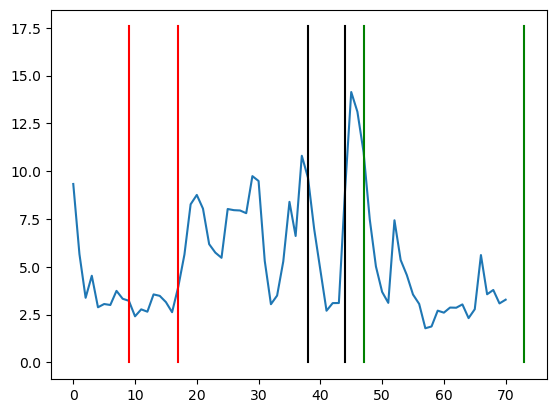

In [14]:
df = pd.DataFrame(
    {
        "template": template_distances,
        "nontemplate": nontemplate_distances,
        "ds": np.array([template_distances, nontemplate_distances]).min(axis=0),
    }
)

df.ds.plot(legend=False)
#sns.lineplot(x=range(len(template_distances_gapped)), y=template_distances_gapped)
plt.plot([9, 9], [0, df.max().iloc[0]], color="red")
plt.plot([17, 17], [0, df.max().iloc[0]], color="red")
#plt.plot([21, 21], [0, df.max().iloc[0]], color="pink")
#plt.plot([26, 26], [0, df.max().iloc[0]], color="pink")
plt.plot([38, 38], [0, df.max().iloc[0]], color="black")
plt.plot([44, 44], [0, df.max().iloc[0]], color="black")
plt.plot([47, 47], [0, df.max().iloc[0]], color="green")
plt.plot([73, 73], [0, df.max().iloc[0]], color="green")
plt.savefig("img/mpic_scp_distances.pdf")